In [1]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
from data_preprocessing_class import TextProcessor
from nltk.sentiment import SentimentIntensityAnalyzer
import math
from collections import defaultdict, Counter
import warnings

In [2]:
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")

reddit_api_info_nw_insights = pd.read_csv("subreddit_data_info_nw_insights.csv")
reddit_api_subreddit_add_info = pd.read_csv("subreddit_data_add_info.csv")
reddit_network_data = pd.read_csv("subreddit_network_data.csv")

merged_data = pd.merge(reddit_api_info_nw_insights, reddit_api_subreddit_add_info, on="Subreddit")
merged_data = pd.merge(merged_data, reddit_network_data, on="Subreddit")
merged_data = merged_data.loc[:, ~merged_data.columns.str.contains('^Unnamed')]

In [3]:
# Comments
comments_df = merged_data[['Subreddit', 'Top 10 Comments']].copy()
comments_df['Top 10 Comments'] = comments_df['Top 10 Comments'].apply(ast.literal_eval)
expanded_comments_df = comments_df.explode('Top 10 Comments').reset_index(drop=True)

processor = TextProcessor()
subreddit_comments_df = processor.text_preprocessed(expanded_comments_df, 'Top 10 Comments')


In [4]:
def sentiment_analysis(df):
    sia = SentimentIntensityAnalyzer()
    df[['negative', 'neutral', 'positive', 'compound']] = df['text_stemmed_no_stopped'].apply(
        lambda x: pd.Series(sia.polarity_scores(x)))

    def get_label(compound):
        if compound > 0.5:
            return 'positive'
        elif compound < -0.5:
            return 'negative'
        else:
            return 'neutral'

    df['vader_sentiment_label'] = df['compound'].apply(get_label)

    return df

                                     Top 10 Comments  negative  positive  \
0  So ferrets are a type of weasel, this is a sto...     0.000     0.000   
1                       It’s a stoat. Great picture!     0.000     0.672   
2  I was also gonna say stoat.  If you have backy...     0.000     0.000   
3  If it went ‘pop’ then it’s definitely a type o...     0.000     0.000   
4  🤣🤣🤣 all I saw was the big ass rock at first an...     0.194     0.139   

   neutral  compound vader_sentiment_label  
0    1.000    0.0000               neutral  
1    0.328    0.6249              positive  
2    1.000    0.0000               neutral  
3    1.000    0.0000               neutral  
4    0.667   -0.2500               neutral  


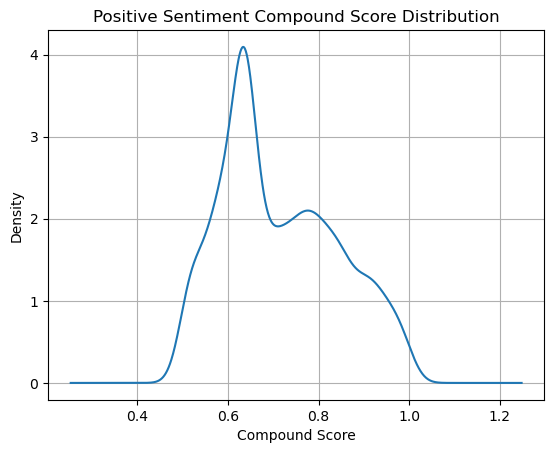

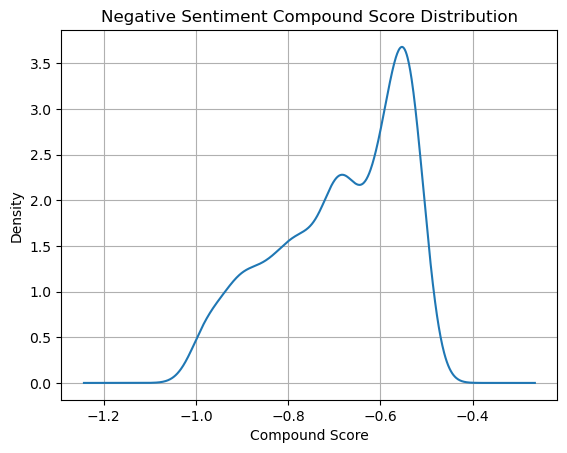

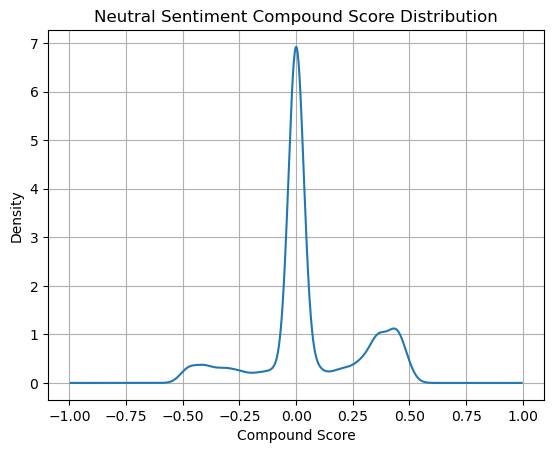

vader_sentiment_label
neutral     0.712391
positive    0.201154
negative    0.086455
Name: proportion, dtype: float64


In [5]:
sentiment_df = sentiment_analysis(subreddit_comments_df)

print(sentiment_df[['Top 10 Comments', 'negative', 'positive', 'neutral', 'compound', 'vader_sentiment_label']].head())

sentiment_df[['Top 10 Comments', 'positive']].sort_values(by='positive', ascending=False).head()

sentiment_df[sentiment_df.vader_sentiment_label == 'positive'].compound.plot.kde()
plt.xlabel('Compound Score')
plt.ylabel('Density')
plt.title('Positive Sentiment Compound Score Distribution')
plt.grid(True)
plt.show()

sentiment_df[['Top 10 Comments', 'negative']].sort_values(by='negative', ascending=False).head()

sentiment_df[sentiment_df.vader_sentiment_label == 'negative'].compound.plot.kde()
plt.xlabel('Compound Score')
plt.ylabel('Density')
plt.title('Negative Sentiment Compound Score Distribution')
plt.grid(True)
plt.show()

sentiment_df[['Top 10 Comments', 'neutral']].sort_values(by='neutral', ascending=False).head()

sentiment_df[sentiment_df.vader_sentiment_label == 'neutral'].compound.plot.kde()
plt.xlabel('Compound Score')
plt.ylabel('Density')
plt.title('Neutral Sentiment Compound Score Distribution')
plt.grid(True)
plt.show()

vader_sentiment = sentiment_df['vader_sentiment_label'].value_counts(normalize=True)
print(vader_sentiment)


In [6]:
# Function to load sentiment words
def load_sentiment_words(positive_file_path, negative_file_path):
    with open(positive_file_path, 'r', encoding='ISO-8859-1') as file:
        positive_words = [line.strip() for line in file if not line.startswith(';') and line.strip() != '']

    with open(negative_file_path, 'r', encoding='ISO-8859-1') as file:
        negative_words = [line.strip() for line in file if not line.startswith(';') and line.strip() != '']

    return set(positive_words), set(negative_words)

In [7]:
# Function to calculate PMI
def calculate_pmi(df, label_column='vader_sentiment_label', positive_file_path='positive-words.txt',
                  negative_file_path='negative-words.txt'):
    positive_words, negative_words = load_sentiment_words(positive_file_path, negative_file_path)

    df = df[~df['Top 10 Comments'].str.startswith('RT')]
    total_tweets = len(df)
    sentiment_counts = df[label_column].value_counts().to_dict()
    p_sentiment = {sentiment: count / total_tweets for sentiment, count in sentiment_counts.items()}
    sentiment_words = defaultdict(list)

    for index, row in df.iterrows():
        sentiment_words[row[label_column]].extend(row['tokens'])

    word_freq = Counter([word for words in sentiment_words.values() for word in words])
    word_freq_sentiment = {sentiment: Counter(words) for sentiment, words in sentiment_words.items()}
    pmi_scores = defaultdict(lambda: defaultdict(lambda: 0))

    for word in positive_words:
        pmi_scores[word]['positive'] = 1
    for word in negative_words:
        pmi_scores[word]['negative'] = 1

    for sentiment, words in word_freq_sentiment.items():
        for word in words.keys():
            p_w_s = words[word] / total_tweets
            p_w = word_freq[word] / total_tweets
            p_s = p_sentiment[sentiment]

            if p_w_s > 0 and p_w > 0 and p_s > 0:
                pmi = math.log(p_w_s / (p_w * p_s), 2)
                pmi_scores[word][sentiment] += pmi

    return pmi_scores

In [9]:
pmi_scores = calculate_pmi(sentiment_df)

positive_words, negative_words = load_sentiment_words('positive-words.txt', 'negative-words.txt')

positive_pmi = {
    word: scores['positive']
    for word, scores in pmi_scores.items()
    if 'positive' in scores and word in positive_words
}

scores = {}
screened = set()

for word, score in sorted(positive_pmi.items(), key=lambda x: -x[1]):
    rounded_score = round(score, 2)
    if rounded_score not in screened:
        screened.add(rounded_score)
        scores[word] = rounded_score
    if len(scores) == 5:
        break

top_5 = list(scores.items())
print(top_5)

negative_pmi = {
    word: scores['negative']
    for word, scores in pmi_scores.items()
    if 'negative' in scores and word in negative_words
}

scores = {}
screened = set()

for word, score in sorted(negative_pmi.items(), key=lambda x: -x[1]):
    rounded_score = round(score, 2)
    if rounded_score not in screened:
        screened.add(rounded_score)
        scores[word] = rounded_score
    if len(scores) == 5:
        break

top_5 = list(scores.items())
print(top_5)

[('passion', 3.31), ('lovely', 3.21), ('pleasure', 3.18), ('freedom', 3.15), ('swift', 3.14)]
[('humiliate', 4.53), ('racism', 4.42), ('loser', 4.36), ('interference', 4.34), ('discomfort', 4.31)]


In [10]:
def determine_pmi_sentiment(tokens, pmi_scores):
    sentiment_score = defaultdict(int)
    for token in tokens:
        for sentiment, score in pmi_scores.get(token, {}).items():
            sentiment_score[sentiment] += score

    if not sentiment_score:
        return 'neutral'

    return max(sentiment_score, key=sentiment_score.get)

In [11]:
sentiment_df['pmi_sentiment'] = sentiment_df['tokens'].apply(lambda x: determine_pmi_sentiment(x, pmi_scores))

comparison_df = sentiment_df[['Top 10 Comments', 'vader_sentiment_label', 'pmi_sentiment']]

pmi_sentiment = sentiment_df['pmi_sentiment'].value_counts(normalize=True)
print(pmi_sentiment)

comparison_df['vader_pmi_match'] = comparison_df['vader_sentiment_label'] == comparison_df['pmi_sentiment']
print(comparison_df['vader_pmi_match'].value_counts(normalize=True))


pmi_sentiment
positive    0.455821
negative    0.451897
neutral     0.092282
Name: proportion, dtype: float64
vader_pmi_match
False    0.637591
True     0.362409
Name: proportion, dtype: float64
